#  Minimum Spanning Tree Problem 
## Single commodity flow formulation



In [1]:
import networkx as nx
import gurobipy as gb
import matplotlib.pyplot as plt
import os

## Drawing functions

In [4]:
def DrawInitG(G, withedges=False):
    
    plt.figure(figsize=args.figsize)
    
    pos = {i:(G.nodes[i]['x'], G.nodes[i]['y']) for i in G.nodes()}
    
    nx.draw_networkx_nodes(G, 
                           pos=pos, 
                           node_shape='o', 
                           node_size=600,
                           node_color='red')
    
    nx.draw_networkx_labels(G, pos=pos, font_color='w', font_size=12)
    
    if withedges:
        nx.draw_networkx_edges(G,pos=pos, alpha=1.0)
        labels = {(i,j):G.get_edge_data(i,j,'cost').get('cost') for i,j in G.edges()}
        nx.draw_networkx_edge_labels(G, pos=pos, edge_labels=labels)
    
    plt.axis('off')
    plt.show()
    
def DrawSol(G, x):
    
    plt.figure(figsize=args.figsize)
    
    pos = {i:(G.nodes[i]['x'], G.nodes[i]['y']) for i in G.nodes()}

    
    nx.draw_networkx_nodes(G, 
                           pos=pos, 
                           node_shape='o', 
                           node_size=600,
                           node_color='red',
                           label=[G.nodes()])
    
    nx.draw_networkx_labels(G, pos=pos, font_color='w', font_size=12)
    
    for u,v in G.edges():
        if x[u,v].x > 0.01 and x[u,v].x < 0.9:
            nx.draw_networkx_edges(G, pos=pos,
                                   edgelist=[(u,v)],
                                   edge_color='r')
            
            nx.draw_networkx_edge_labels(G, pos=pos,
                                         edge_labels={(u,v):'{:.2f}'.format(x[u,v].x)})
        
        if x[u,v].x > 0.9:
            nx.draw_networkx_edges(G, pos=pos,
                                   edgelist=[(u,v)],
                                   edge_color='k')
        

    
    #edges_in_sol = [(u,v)  for u,v in G.edges() if x[u,v].x > 0.1]

    
    plt.axis('off')
    plt.show()
    
def DrawSolFlow (G,x,f):
    
    plt.figure(figsize=args.figsize)
    
    pos = {i:(G.nodes[i]['x'], G.nodes[i]['y']) for i in G.nodes()}
    
    nx.draw_networkx_nodes(G, 
                           pos=pos,  
                           node_shape='o', 
                           node_size=600,
                           node_color='r', 
                           label=[G.nodes()])
    
    nx.draw_networkx_nodes(G, 
                           pos=pos, 
                           nodelist = [root], 
                           node_shape='o',
                           node_size=600,
                           node_color='k', 
                           label=[G.nodes()])
    
    nx.draw_networkx_labels(G, pos=pos, font_color='w')
    
    for h,k in G.edges():
        
        flow = abs(f[h,k].x - f[k,h].x)
        
        

        G[h][k]['capacity'] = x[h,k].x
        if x[h,k].x > 0.00001:
            if x[h,k].x > 0.999999:
                nx.draw_networkx_edges(G, 
                                       pos=pos, 
                                       edgelist=[(h,k)],
                                       edge_color='k')
                
                nx.draw_networkx_edge_labels(G, 
                                             pos=pos,
                                             edge_labels={(h,k):'{:.2f}'.format(flow)})
            else:
                nx.draw_networkx_edges(G, 
                                       pos=pos, 
                                       edgelist=[(h,k)],
                                       edge_color='r')

    plt.axis('off')
    plt.show()
    
class args:
    filename = None
    figsize = 30,60
    scale = 40

In [5]:
args.filename = "graph.gml"
args.scale = 20
args.figsize = (10,10)

basename = os.path.splitext(args.filename)[0]
G = nx.read_graphml (args.filename, node_type=int)

print ("G has", G.number_of_nodes(), "nodes and", G.number_of_edges(), "edges")

G has 10 nodes and 45 edges


## Single commodity flow formulation

$$
x_e = \begin{cases}
1 \text{ if edge $e$ is in the tree} \\
0 \text { otherwise}
\end{cases}
$$

Associate to each edge $e$ two directed arcs $(i,j)$ and $(j,i)$ and let 

$$
f_{ij} = \{\text{flow carried by the arc} (i,j)\}
$$

\begin{alignat}{3}
\min cx &&\\
\sum_{e \in E} x_e = n - 1 && \\
\sum_{j \in \delta^+(0)} f_{0j} - \sum_{j \in \delta^-(0)} f_{j0} = n - 1 &&\\
\sum_{j \in \delta^-(v)} f_{jv} - \sum_{j \in \delta^+(v)} f_{vj} = 1 &&\;\; \forall v \in V, v \not = \{0\} \\
f_{ij} \le (n-1)x_e &&\;\; \forall e \in E, e=\{i,j\}\\
f_{ji} \le (n-1)x_e &&\;\; \forall e \in E, e=\{i,j\}\\
f \ge 0, \; x_e \in \{0,1\}
\end{alignat}

In [6]:
G.nodes(data=True)

NodeDataView({1: {'y': 33, 'x': 1}, 2: {'y': 16, 'x': 26}, 3: {'y': 25, 'x': 19}, 4: {'y': 30, 'x': 27}, 5: {'y': 17, 'x': 28}, 6: {'y': 5, 'x': 23}, 7: {'y': 28, 'x': 23}, 8: {'y': 25, 'x': 24}, 9: {'y': 39, 'x': 3}, 10: {'y': 20, 'x': 11}})

In [7]:
G = nx.convert_node_labels_to_integers(G, first_label=0,label_attribute='old' )

In [8]:
G.nodes(data=True)

NodeDataView({0: {'y': 33, 'x': 1, 'old': 1}, 1: {'y': 16, 'x': 26, 'old': 2}, 2: {'y': 25, 'x': 19, 'old': 3}, 3: {'y': 30, 'x': 27, 'old': 4}, 4: {'y': 17, 'x': 28, 'old': 5}, 5: {'y': 5, 'x': 23, 'old': 6}, 6: {'y': 28, 'x': 23, 'old': 7}, 7: {'y': 25, 'x': 24, 'old': 8}, 8: {'y': 39, 'x': 3, 'old': 9}, 9: {'y': 20, 'x': 11, 'old': 10}})

## Solve the MST with the combinatorial algorithm

In [9]:
T = nx.minimum_spanning_tree(G, weight='cost')

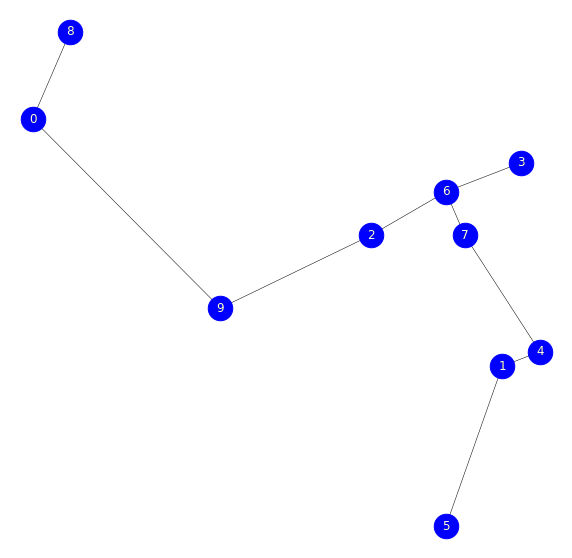

In [10]:
plt.figure(figsize=args.figsize)


pos = {i:(G.nodes[i]['x'], G.nodes[i]['y']) for i in G.nodes()}

nx.draw_networkx(T, 
                 pos=pos, 
                 width=0.5, 
                 node_shape='o', 
                 node_size=600,
                 node_color='blue')

nx.draw_networkx_labels(T, pos=pos, font_color='w', font_size=12);

  
plt.axis('off')
plt.show()

In [11]:
root = 0

args.figsize=(10,10)

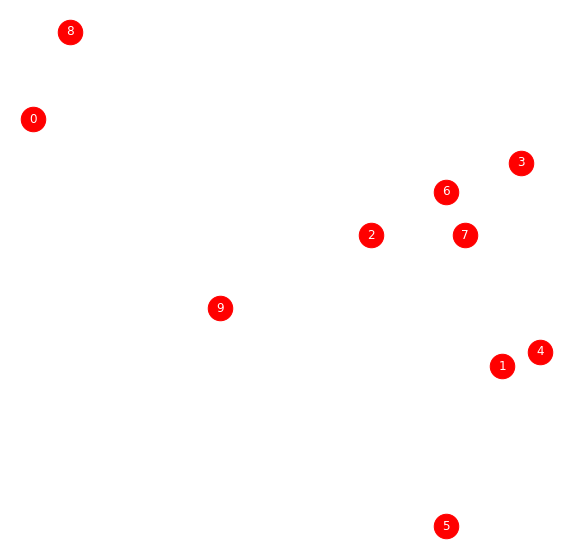

In [12]:
DrawInitG(G)

# Define a Directed Graph by doubling the edges of G

D = G.to_directed()

In [13]:
mstflow = gb.Model()

Academic license - for non-commercial use only - expires 2021-07-16
Using license file /home/leonardo/gurobi.lic


In [14]:
x = mstflow.addVars(G.edges(), obj=[G[u][v]['cost'] for u,v in G.edges()],
                    ub = 1.0,
                    vtype=gb.GRB.BINARY,
                    name='x')

f = mstflow.addVars(D.edges(), ub=G.number_of_nodes(), vtype=gb.GRB.CONTINUOUS, name='f')



In [15]:
mstflow.addConstr(x.sum() == G.number_of_nodes() - 1, 'Cardinality')

mstflow.update()

In [16]:
mstflow.addConstr(f.sum(root, '*') - f.sum('*', root) == G.number_of_nodes() - 1, \
                  'Flow_at_root')

mstflow.update()

In [17]:
#
# Root is the first nodes
# The iterator moves one step ahead
#


for v in G.nodes():
    if v != root:
        name = 'Balance_' + str(v)
        mstflow.addConstr(f.sum('*',v) - f.sum(v,'*') == 1, name=name)
    
mstflow.update()



In [18]:
for e in G.edges():
    
    h = e[0]
    k = e[1]
        
    name = "Force_f(%d,%d)_x(%d,%d)" % (h, k, e[0], e[1])
    mstflow.addConstr(f[h,k] <= (G.number_of_nodes() - 1) * x[e], name=name)

    name = "Force_f(%d,%d)_x(%d,%d)" % (k, h, e[0], e[1])
    mstflow.addConstr(f[k,h] <= (G.number_of_nodes() - 1) * x[e], name=name)

mstflow.update()
mstflow.write('mstflow.lp')

In [19]:
mstflow.optimize()

Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (linux64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 101 rows, 135 columns and 405 nonzeros
Model fingerprint: 0x6d097c73
Variable types: 90 continuous, 45 integer (45 binary)
Coefficient statistics:
  Matrix range     [1e+00, 9e+00]
  Objective range  [2e+02, 4e+03]
  Bounds range     [1e+00, 1e+01]
  RHS range        [1e+00, 9e+00]
Found heuristic solution: objective 14550.000000
Presolve time: 0.00s
Presolved: 101 rows, 135 columns, 405 nonzeros
Variable types: 90 continuous, 45 integer (45 binary)

Root relaxation: objective 5.746667e+03, 57 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 5746.66667    0    5 14550.0000 5746.66667  60.5%     -    0s
H    0     0                    7002.0000000 5746.66667  17.9%     -    0s
     0     0 6507

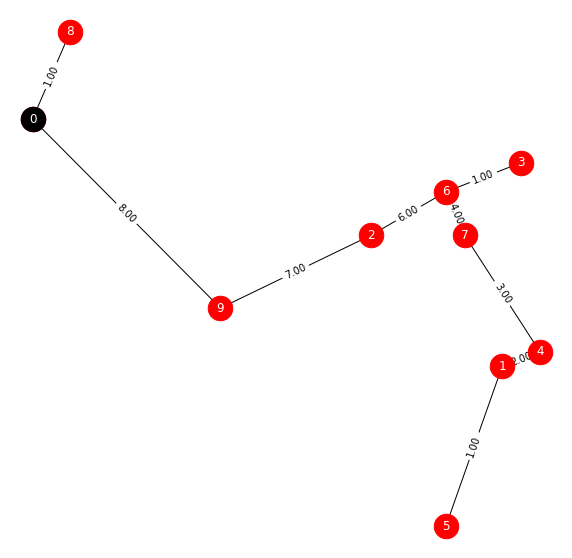

In [20]:
DrawSolFlow(G, x, f)



## Degree constrained spanning tree

$$ \sum_{e \in \delta(0)} x_e \le \Delta$$ 

In [21]:
rootdeg = 5

mstflow.addConstr(gb.quicksum([x[e] for e in G.edges(root)]), \
                  sense='<=', rhs=rootdeg, name='RootDegree')

mstflow.update()


mstflow.write('mst_deg.lp')

In [22]:
mstflow.optimize()

Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (linux64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 102 rows, 135 columns and 414 nonzeros
Model fingerprint: 0x689ea2b7
Variable types: 90 continuous, 45 integer (45 binary)
Coefficient statistics:
  Matrix range     [1e+00, 9e+00]
  Objective range  [2e+02, 4e+03]
  Bounds range     [1e+00, 1e+01]
  RHS range        [1e+00, 9e+00]

MIP start from previous solve produced solution with objective 6735 (0.01s)
Loaded MIP start from previous solve with objective 6735

Presolve time: 0.00s
Presolved: 102 rows, 135 columns, 414 nonzeros
Variable types: 90 continuous, 45 integer (45 binary)

Root relaxation: objective 5.746667e+03, 72 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 5746.66667    0    5 6735.00000 5746.66667  14.7%     -    0s
     0

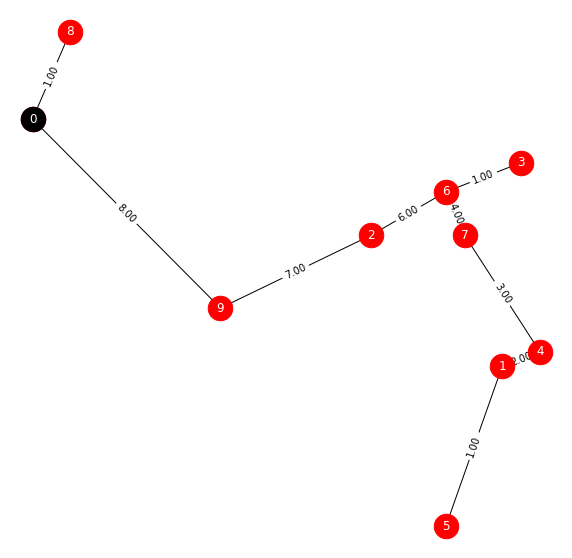

In [23]:
DrawSolFlow(G, x, f)


The next statement remove the ``RootDegree`` constraint

In [24]:
mstflow.remove(mstflow.getConstrByName('RootDegree'))

mstflow.update()

mstflow.write('mst_deg.lp')

## Capacitated spanning tree

In [25]:
subtreecap = 7

for i in f:
    f[i].ub = subtreecap

In [26]:
mstflow.optimize()

Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (linux64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 101 rows, 135 columns and 405 nonzeros
Model fingerprint: 0x08ab1a9a
Variable types: 90 continuous, 45 integer (45 binary)
Coefficient statistics:
  Matrix range     [1e+00, 9e+00]
  Objective range  [2e+02, 4e+03]
  Bounds range     [1e+00, 7e+00]
  RHS range        [1e+00, 9e+00]

MIP start from previous solve did not produce a new incumbent solution

Presolve time: 0.00s
Presolved: 101 rows, 135 columns, 405 nonzeros
Variable types: 90 continuous, 45 integer (45 binary)
Found heuristic solution: objective 21270.000000

Root relaxation: objective 6.115429e+03, 62 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 6115.42857    0    5 21270.0000 6115.42857  71.2%     -    0s
H    0     0       

In [27]:
mstflow.write('mst_deg.lp')

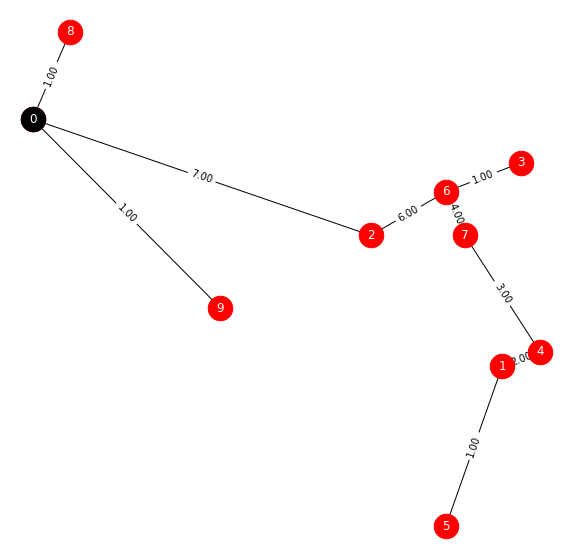

In [28]:
DrawSolFlow(G, x, f)
